# Probabilistic CLV Modeling on Olist E-Commerce Data (BG/NBD & Gamma-Gamma)
**Author:** Barış Eren Şahin

## Project Goal & Motivation
In this project, I wanted to go beyond standard "Churn" classification models and tackle the common "one-time buyer" problem in e-commerce using probabilistic models. While exploring Olist’s relational database (which has 9 different tables), I noticed that a huge majority of customers only shopped once. Because of this, instead of just doing a basic binary churn prediction, I decided to model the future purchase frequencies and the expected average profit (Customer Lifetime Value) of the customers.

## Methodologies Used
ETL & Data Cleaning: Merging 3 core tables using a Pandas & SQL-like approach to create a master dataset.

BG/NBD Model: Predicting future transaction counts using Poisson and Gamma distributions.

Gamma-Gamma Model: Estimating the future monetary value (monetary prediction).

Time-Based Backtesting: Validating the model's accuracy and checking statistical assumptions.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from lifetimes.utils import summary_data_from_transaction_data, calibration_and_holdout_data
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

orders = pd.read_csv('data/olist_orders_dataset.csv')
customers = pd.read_csv('data/olist_customers_dataset.csv')
payments = pd.read_csv('data/olist_order_payments_dataset.csv')

print(f"Orders tablosu boyutu: {orders.shape}")
display(orders.head(3))


print("\n--- Orders Table ---")
orders.info()

print("\n--- Customers Table---")
customers.info()

print("\n--- Payments Table ---")
payments.info()

Orders tablosu boyutu: (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00



--- Orders Table ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB

--- Customers Table---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 


# EDA

In [2]:
print(f"Shape of the orders table: {orders.shape}")
display(orders.head(3))

print("\n--- Orders Table Details ---")
orders.info()

print("\n--- Customers Table Details ---")
customers.info()

print("\n--- Payments Tablosu Details ---")
payments.info()

Shape of the orders table: (99441, 8)


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-04 19:55:00,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-08 13:50:00,2018-08-17 18:06:29,2018-09-04 00:00:00



--- Orders Table Details ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99441 non-null  object
 1   customer_id                    99441 non-null  object
 2   order_status                   99441 non-null  object
 3   order_purchase_timestamp       99441 non-null  object
 4   order_approved_at              99281 non-null  object
 5   order_delivered_carrier_date   97658 non-null  object
 6   order_delivered_customer_date  96476 non-null  object
 7   order_estimated_delivery_date  99441 non-null  object
dtypes: object(8)
memory usage: 6.1+ MB

--- Customers Table Details ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    ------

In [3]:
status_counts = orders['order_status'].value_counts()
print("Distribution of Order Status:")
print(status_counts)

# Total number of canceled and unavailable orders
# These represent non-revenue generating transactions (lost revenue)
bad_orders = status_counts.get('canceled', 0) + status_counts.get('unavailable', 0)
print(f"\nTotal non-revenue generating orders (canceled/unavailable): {bad_orders}")

Distribution of Order Status:
order_status
delivered      96478
shipped         1107
canceled         625
unavailable      609
invoiced         314
processing       301
created            5
approved           2
Name: count, dtype: int64

Total non-revenue generating orders (canceled/unavailable): 1234


In [4]:
# I Converted the timestamp column from object (string) to a datetime format
orders['order_purchase_timestamp'] = pd.to_datetime(orders['order_purchase_timestamp'])

# Determine the first and last order dates to establish the total timeframe available for our CLV (Customer Lifetime Value) modeling
first_order = orders['order_purchase_timestamp'].min()
last_order = orders['order_purchase_timestamp'].max()
time_span = last_order - first_order

print(f"First order date: {first_order}")
print(f"Last order date: {last_order}")
print(f"Total timeframe covered by the dataset: {time_span}")

First order date: 2016-09-04 21:15:19
Last order date: 2018-10-17 17:30:18
Total timeframe covered by the dataset: 772 days 20:14:59


In [5]:
# I converted the unique order IDs from both tables into sets to compare them easily.
order_ids_in_orders = set(orders['order_id'])
order_ids_in_payments = set(payments['order_id'])

# Let's find the difference (orders that exist but have no payment record)
missing_payments = order_ids_in_orders - order_ids_in_payments

print(f"Total orders in the 'orders' table: {len(order_ids_in_orders)}")
print(f"Orders with a payment record in 'payments' table: {len(order_ids_in_payments)}")
print(f"Number of orders that have NO payment record at all: {len(missing_payments)}")

Total orders in the 'orders' table: 99441
Orders with a payment record in 'payments' table: 99440
Number of orders that have NO payment record at all: 1


In [6]:
# Let's look at the statistical summary of payment values
print("--- Payment Value Statistics ---")
print(payments['payment_value'].describe())

# Checking if there are any payments with a value of zero
zero_payments = payments[payments['payment_value'] == 0]
print(f"\nNumber of transactions with a zero (0) payment value: {len(zero_payments)}")

--- Payment Value Statistics ---
count    103886.000000
mean        154.100380
std         217.494064
min           0.000000
25%          56.790000
50%         100.000000
75%         171.837500
max       13664.080000
Name: payment_value, dtype: float64

Number of transactions with a zero (0) payment value: 9


**What we want to find out:**
In order to calculate 'Monetary' value later for the model, we need to look for extreme outliers in the payment column and ANY orders that were completely free (0 payment due to discount coupon).

# ETL PipeLine

- If I just use a direct `pd.merge()`, orders with multiple payment records (e.g., paying with a voucher + credit card) will cause duplicate rows in the dataset.
- To prevent this duplication, I am grouping the `payments` table by `order_id` and aggregating the values first.

In [7]:
# Removing canceled and unavailable orders
valid_statuses = ['delivered', 'shipped', 'invoiced', 'processing', 'approved']
valid_orders = orders[orders['order_status'].isin(valid_statuses)].copy()

# Let's drop the zero-value (invalid) payments first
valid_payments = payments[payments['payment_value'] > 0]

# If an order has multiple payment rows, we aggregate their values
# (e.g., order_id: 123 -> Credit Card: 100, Voucher: 50 => Total: 150)
order_payments_agg = valid_payments.groupby('order_id', as_index=False)['payment_value'].sum()

print("Merging tables...")

# Orders & Payments (Inner join: Keeps only valid orders that have a payment record)
df_merged = pd.merge(valid_orders, order_payments_agg, on='order_id', how='inner')

# Add the customers table (Matching on 'customer_id' to get 'customer_unique_id')
df_merged = pd.merge(df_merged, customers, on='customer_id', how='inner')

# Creating the "Master Table" required for CLV (Customer Lifetime Value) modeling
# We only care about WHO (customer_unique_id), WHEN (order_purchase_timestamp), and HOW MUCH (payment_value) they spent.
master_df = df_merged[['customer_unique_id', 'order_id', 'order_purchase_timestamp', 'payment_value']].copy()

# Ensure the timestamp column is in proper datetime format
master_df['order_purchase_timestamp'] = pd.to_datetime(master_df['order_purchase_timestamp'])

print(f"Initial number of orders: {len(orders)}")
print(f"Number of rows in the cleaned Master Table: {len(master_df)}")
display(master_df.head())

Merging tables...
Initial number of orders: 99441
Number of rows in the cleaned Master Table: 98201


,customer_unique_id,order_id,order_purchase_timestamp,payment_value
0,7c396fd4830fd04220f754e42b4e5bff,e481f51cbdc54678b7cc49136f2d6af7,2017-10-02 10:56:33,38.71
1,af07308b275d755c9edb36a90c618231,53cdb2fc8bc7dce0b6741e2150273451,2018-07-24 20:41:37,141.46
2,3a653a41f6f9fc3d2a113cf8398680e8,47770eb9100c2d0c44946d9cf07ec65d,2018-08-08 08:38:49,179.12
3,7c142cf63193a1473d2e66489a9ae977,949d5b44dbf5de918fe9c16f97b45f8a,2017-11-18 19:28:06,72.20
4,72632f0f9dd73dfee390c9b22eb56dd6,ad21c59c0840e6cb83a9ceb5573f8159,2018-02-13 21:18:39,28.62


# RFM

In [8]:
# 1. Defining the Analysis Date (Reference Date)
# In real-world projects, we would normally use dt.date.today(). 
# Since this is a historical dataset, I am setting the reference date to 1 day after the very last purchase in the data.
last_date_in_data = master_df['order_purchase_timestamp'].max()
analysis_date = last_date_in_data + dt.timedelta(days=1)

print(f"Last transaction in the dataset: {last_date_in_data}")
print(f"Analysis (Reference) Date: {analysis_date}\n")

# 2. Calculating RFM Metrics
# Grouping customers by their unique IDs and applying aggregations
rfm = master_df.groupby('customer_unique_id').agg(
    # Recency: (Analysis Date - Customer's LAST order date in days)
    Recency=('order_purchase_timestamp', lambda date: (analysis_date - date.max()).days),
    
    # Frequency: Total number of unique orders per customer (nunique)
    Frequency=('order_id', 'nunique'),
    
    # Monetary: Total amount spent (sum)
    Monetary=('payment_value', 'sum')
)

# 3. Making column names lowercase for easier access
rfm.columns = ['recency', 'frequency', 'monetary']

# Keeping only customers with a monetary value greater than 0 
# (This filters out fully refunded or zero-value customers)
rfm = rfm[rfm['monetary'] > 0]

print(f"Total Number of Unique Customers: {len(rfm)}")
print("\n--- First 5 Rows of the RFM Table ---")
display(rfm.head())

print("\n--- RFM Statistics ---")
display(rfm.describe())

Last transaction in the dataset: 2018-09-03 09:06:57
Analysis (Reference) Date: 2018-09-04 09:06:57

Total Number of Unique Customers: 94985

--- First 5 Rows of the RFM Table ---


,recency,frequency,monetary
customer_unique_id,,,
0000366f3b9a7992bf8c76cfdf3221e2,116,1,141.90
0000b849f77a49e4a4ce2b2a4ca5be3f,119,1,27.19
0000f46a3911fa3c0805444483337064,542,1,86.22
0000f6ccb0745a6a4b88665a16c9f078,326,1,43.62
0004aac84e0df4da2b147fca70cf8255,293,1,196.89



--- RFM Statistics ---


,recency,frequency,monetary
count,94985.000000,94985.000000,94985.000000
mean,243.442449,1.033858,165.694045
std,152.995982,0.210809,226.745412
min,1.000000,1.000000,9.590000
25%,119.000000,1.000000,63.100000
50%,224.000000,1.000000,107.900000
75%,352.000000,1.000000,182.940000
max,729.000000,16.000000,13664.080000


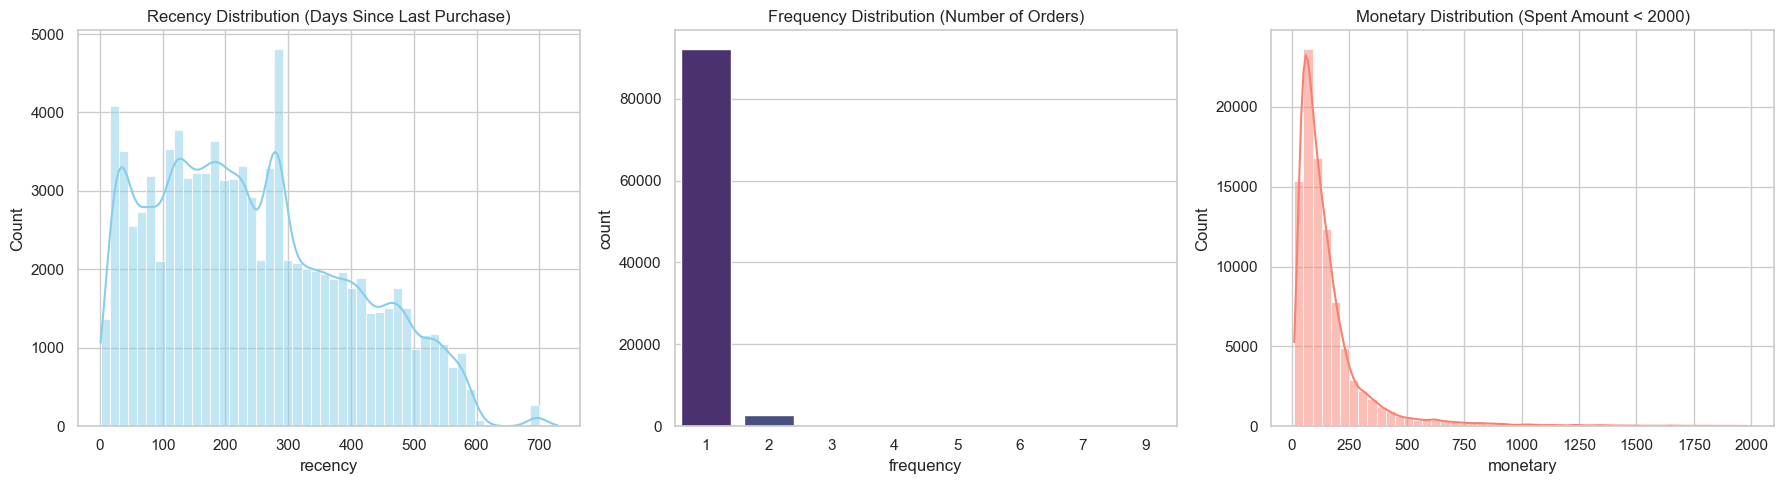


Total Number of Customers: 94985
Number of One-Time Buyers: 92098
One-Time Buyer Ratio: 96.96%
Revenue contribution of the top 5 customers: 0.27%


In [9]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Recency Distribution
sns.histplot(rfm['recency'], bins=50, kde=True, ax=axes[0], color='skyblue')
axes[0].set_title('Recency Distribution (Days Since Last Purchase)')

# 2. Frequency Distribution (Plotting orders < 10 for better readability)
sns.countplot(x=rfm[rfm['frequency'] < 10]['frequency'], ax=axes[1], palette='viridis')
axes[1].set_title('Frequency Distribution (Number of Orders)')

# 3. Monetary Distribution (Cropped extreme outliers for better visibility)
sns.histplot(rfm[rfm['monetary'] < 2000]['monetary'], bins=50, kde=True, ax=axes[2], color='salmon')
axes[2].set_title('Monetary Distribution (Spent Amount < 2000)')

plt.tight_layout()
plt.show()

# Let's find the ratio of customers who purchased only once
one_time_buyers = len(rfm[rfm['frequency'] == 1])
total_customers = len(rfm)
one_time_ratio = (one_time_buyers / total_customers) * 100

print(f"\nTotal Number of Customers: {total_customers}")
print(f"Number of One-Time Buyers: {one_time_buyers}")
print(f"One-Time Buyer Ratio: {one_time_ratio:.2f}%")

# Let's check the revenue contribution of the top 5 highest-spending (VIP) customers
top_5_revenue = rfm['monetary'].nlargest(5).sum()
total_revenue = rfm['monetary'].sum()
top_5_ratio = (top_5_revenue / total_revenue) * 100

print(f"Revenue contribution of the top 5 customers: {top_5_ratio:.2f}%")

### Business Insights
The analysis of the data shows that "e-commerce platform" has an extremely high percentage of one time buyers of **96.96%**.

The extreme difference in the number of one time "e-commerce platform" buyers to recurrent buyers will make it nearly impossible to create a valid second order churn model. Therefore, I decided to build a probabilistic **CLV model** using the BG/NBD distribution for predicting future purchase frequencies and the **Gamma-Gamma model** for estimating expected profits.

My logic is simple; if the company has limited funds for marketing then it makes much better business sense to spend those funds in a more efficient manner. This means that rather than trying to market to everyone in the marketplace the marketing budget should be spent on retaining the loyal 3% of customers and identifying the specific one time buyers who have the highest likelihood of making a return purchase.

# BG/NBD MODEL

This model predicts the future purchase frequency of the customers.

In [10]:
# Important Note: In the lifetimes package, 'frequency' strictly counts REPEAT purchases.
# (It drops the first purchase of every customer, unlike a standard groupby count).

# 1. Formatting the data for the probabilistic model (Lifetimes library)
clv_data = summary_data_from_transaction_data(
    master_df, 
    'customer_unique_id', 
    'order_purchase_timestamp', 
    monetary_value_col='payment_value', 
    observation_period_end=analysis_date
)

print("Lifetimes RFM Summary Data is Ready:")
display(clv_data.head())

# 2. Initializing the BG/NBD Model:
bgf = BetaGeoFitter(penalizer_coef=0.001) 

# Fitting the model
bgf.fit(clv_data['frequency'], clv_data['recency'], clv_data['T'])
print("\nBG/NBD Model successfully fitted!")

# 3. Predicting future transactions for the next 6 months
t = 180 # 180 days
clv_data['expected_purchases_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    t, clv_data['frequency'], clv_data['recency'], clv_data['T']
)

print("\n--- Top 10 Customers Expected to Make the Most Purchases in the Next 6 Months ---")
display(clv_data.sort_values(by='expected_purchases_6_months', ascending=False).head(10))

Lifetimes RFM Summary Data is Ready:


,frequency,recency,T,monetary_value
customer_unique_id,,,,
0000366f3b9a7992bf8c76cfdf3221e2,0.0,0.0,117.0,0.0
0000b849f77a49e4a4ce2b2a4ca5be3f,0.0,0.0,120.0,0.0
0000f46a3911fa3c0805444483337064,0.0,0.0,543.0,0.0
0000f6ccb0745a6a4b88665a16c9f078,0.0,0.0,327.0,0.0
0004aac84e0df4da2b147fca70cf8255,0.0,0.0,294.0,0.0



BG/NBD Model successfully fitted!

--- Top 10 Customers Expected to Make the Most Purchases in the Next 6 Months ---


,frequency,recency,T,monetary_value,expected_purchases_6_months
customer_unique_id,,,,,
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,477.0,58.618000,4.496535
ca77025e7201e3b30c44b472ff346268,6.0,235.0,330.0,138.941667,1.841812
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,256.0,149.282500,1.750833
6469f99c1f9dfae7733b25662e7f1782,5.0,282.0,350.0,133.412000,1.642745
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,430.0,151.606000,1.539148
e0836a97eaae86ac4adc26fbb334a527,2.0,62.0,70.0,32.955000,1.534618
bc3e7032668d3f411c227eec09221362,2.0,59.0,81.0,72.535000,1.356962
fe81bb32c243a86b2f86fbf053fe6140,4.0,242.0,317.0,381.745000,1.346395
63cfc61cee11cbe306bff5857d00bfe4,5.0,382.0,481.0,135.432000,1.247650


## Model of Gamma-Gamma

### Predicting Future Spending (Monetary Value)
- This model tries to guess how much money a customer will spend in the future.
- But there is a catch: the math behind this model only works for "repeat buyers" (customers who shopped more than once). 
- That's why I had to filter the dataset and keep only the rows where `monetary > 0` and `frequency > 0`.
- Because of this rule, I literally had to drop about 97% of the dataset! It sounds crazy to throw away that much data, but since they are all one-time buyers, the model simply can't process them.

In [11]:
!pip install lifetimes

In [12]:
# This handy function calculates recency, frequency, monetary, and T (Age) values automatically for us.
clv_data = summary_data_from_transaction_data(
    master_df, 
    'customer_unique_id', 
    'order_purchase_timestamp', 
    monetary_value_col='payment_value', 
    observation_period_end=analysis_date
)

# Filtering the data
# We only keep the ones who actually bought something more than once
clv_data = clv_data[(clv_data['frequency'] > 0) & (clv_data['monetary_value'] > 0)]

print(f"Number of repeat customers ready for modeling: {len(clv_data)}\n")

# MODEL 1: BG/NBD (Predicting Future Purchase Counts) 
print("2. Training the BG/NBD Model (Purchase Frequency Prediction)...")
bgf = BetaGeoFitter(penalizer_coef=0.001) # A small penalty term to avoid overfitting
bgf.fit(clv_data['frequency'], clv_data['recency'], clv_data['T'])

# Expected number of purchases for the future (Next 180 days)
clv_data['expected_purchases_6_months'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, clv_data['frequency'], clv_data['recency'], clv_data['T']
)

# MODEL 2: GAMMA-GAMMA (Predicting Future Monetary Value) ---
print("3. Training the Gamma-Gamma Model (Monetary Value Prediction)...")
ggf = GammaGammaFitter(penalizer_coef=0.01)
ggf.fit(clv_data['frequency'], clv_data['monetary_value'])

# Expected average profit/value per transaction
clv_data['expected_average_value'] = ggf.conditional_expected_average_profit(
    clv_data['frequency'], clv_data['monetary_value']
)

# THE GRAND FINALE: Calculating CLV (Customer Lifetime Value)
# 6-Month CLV = (Expected purchases in 6 months) * (Expected average transaction value)
clv_data['6_month_CLV'] = clv_data['expected_purchases_6_months'] * clv_data['expected_average_value']

print("\n--- Top 10 VIP Customers with the Highest 6-Month CLV ---")
display(clv_data.sort_values(by='6_month_CLV', ascending=False).head(10))

Number of repeat customers ready for modeling: 2064

2. Training the BG/NBD Model (Purchase Frequency Prediction)...
3. Training the Gamma-Gamma Model (Monetary Value Prediction)...

--- Top 10 VIP Customers with the Highest 6-Month CLV ---


,frequency,recency,T,monetary_value,expected_purchases_6_months,expected_average_value,6_month_CLV
customer_unique_id,,,,,,,
4facc2e6fbc2bffab2fea92d2b4aa7e4,3.0,421.0,443.0,532.320000,0.638511,556.245045,355.168443
fe81bb32c243a86b2f86fbf053fe6140,4.0,242.0,317.0,381.745000,0.711771,394.758793,280.977815
397b44d5bb99eabf54ea9c2b41ebb905,3.0,157.0,236.0,489.963333,0.514879,512.091085,263.664953
c8460e4251689ba205045f3ea17884a1,1.0,1.0,28.0,2405.280000,0.095034,2744.243461,260.797399
8d50f5eadf50201ccdcedfb9e2ac8455,15.0,462.0,477.0,58.618000,2.990804,59.357837,177.527649
dc813062e0fc23409cd255f7f53c7074,5.0,418.0,430.0,151.606000,1.131731,156.190461,176.765621
394ac4de8f3acb14253c177f0e15bc58,4.0,236.0,256.0,149.282500,1.052109,154.976000,163.051645
297ec5afd18366f5ba27520cc4954151,2.0,85.0,200.0,701.160000,0.209913,748.804825,157.183827
d132b863416f85f2abb1a988ca05dd12,2.0,341.0,386.0,390.170000,0.360565,417.591713,150.568783


# MODEL VALIDATION

### Quick Statistical Sanity Check
- The Gamma-Gamma model has one strict mathematical rule: 
- It assumes that there is absolutely NO linear relationship (correlation) between a customer's shopping frequency and the money they drop (monetary value).

In [13]:
# Let's check the correlation to see if we break the model's golden rule
correlation = clv_data[['frequency', 'monetary_value']].corr().iloc[0, 1]

print("--- 1. GAMMA-GAMMA SANITY CHECK ---")
print(f"Correlation between Frequency and Monetary: {correlation:.4f}")

if abs(correlation) < 0.1:
    print("Conclusion: Correlation is super low (almost zero). The Gamma-Gamma model is SAFE to use!")
else:
    print("Conclusion: Uh-oh, correlation is too high. We are violating the model's main assumption!")

--- 1. GAMMA-GAMMA SANITY CHECK ---
Correlation between Frequency and Monetary: -0.0006
Conclusion: Correlation is super low (almost zero). The Gamma-Gamma model is SAFE to use!


### Splitting of Train-Test and Backtesting


--- 2. TIME-BASED MODEL VALIDATION (BACKTESTING) ---
Splitting the timeline: First part is for 'Training (Calibration)', last 6 months for 'Testing (Holdout)'...


<Figure size 800x600 with 0 Axes>

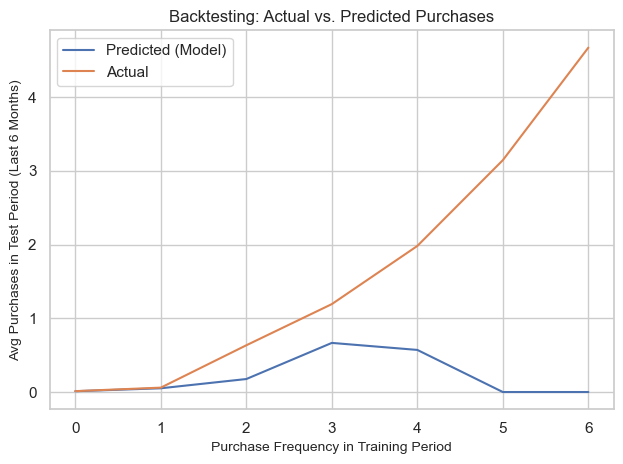

In [14]:
print("\n--- 2. TIME-BASED MODEL VALIDATION (BACKTESTING) ---")
print("Splitting the timeline: First part is for 'Training (Calibration)', last 6 months for 'Testing (Holdout)'...")

# Setting the training end date to exactly 180 days (6 months) before our analysis date
calibration_period_end = analysis_date - dt.timedelta(days=180)

# Using the Lifetimes library's built-in function to split the data chronologically
holdout_data = calibration_and_holdout_data(
    master_df, 
    'customer_unique_id', 
    'order_purchase_timestamp',
    calibration_period_end=calibration_period_end,
    observation_period_end=analysis_date
)

# Training the model from scratch using ONLY the training (calibration) data
bgf_val = BetaGeoFitter(penalizer_coef=0.001)
bgf_val.fit(holdout_data['frequency_cal'], holdout_data['recency_cal'], holdout_data['T_cal'])

# Plotting what actually happened vs. what our model predicted during the test period
plt.figure(figsize=(8, 6))

# This cool function draws the model's predictions and the actual results on top of each other. 
# If the lines are hugging each other closely, it means our model is doing a great job!
plot_calibration_purchases_vs_holdout_purchases(bgf_val, holdout_data)

plt.title('Backtesting: Actual vs. Predicted Purchases', fontsize=12)
plt.ylabel('Avg Purchases in Test Period (Last 6 Months)', fontsize=10)
plt.xlabel('Purchase Frequency in Training Period', fontsize=10)
plt.legend(['Predicted (Model)', 'Actual'])
plt.tight_layout()
plt.show()

### Turning Model Outputs into Real Business Value
- After training the models and making sure they actually work with backtesting, I ended up with a bunch of raw CLV scores. 
- But let's be honest, raw math doesn't mean much to a marketing team. So, I applied segmentation to group these customers into a format that marketers can easily understand and act on.
- My whole goal here was to simulate a real-world scenario: If the marketing department has a limited campaign budget, I want to help them target the right audience (our VIPs) instead of wasting money on people who won't come back.

--- 6-Month CLV Segmentation Summary ---


,Number of Customers,Avg CLV ($),Total Expected Revenue ($)
Segment,,,
Low_Value,516,0.467364,241.160002
Mid_Value,516,1.857347,958.390900
High_Value,516,4.958855,2558.769197
VIP,516,25.737021,13280.302955


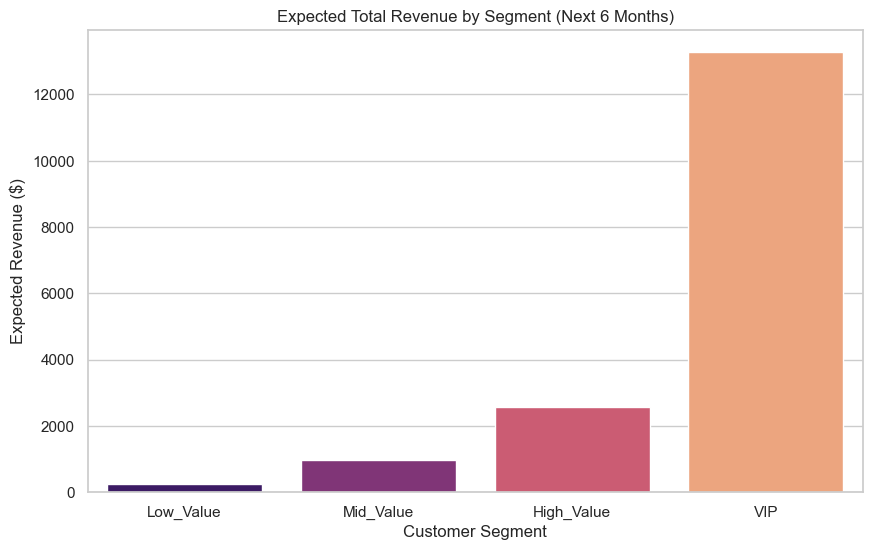


# Strategic Insight #
Even though our VIP customers make up only 25% of the user base, they are expected to generate 77.9% of our total revenue in the next 6 months! We should definitely focus our marketing budget here.


In [15]:
# 1. Splitting our customers into 4 tiers based on their expected CLV (using quartiles)
clv_data['Segment'] = pd.qcut(clv_data['6_month_CLV'], 4, labels=['Low_Value', 'Mid_Value', 'High_Value', 'VIP'])

# 2. Let's see what these segments actually mean for the business
segment_summary = clv_data.groupby('Segment', observed=True)['6_month_CLV'].agg(['count', 'mean', 'sum'])
segment_summary = segment_summary.rename(columns={
    'count': 'Number of Customers', 
    'mean': 'Avg CLV ($)', 
    'sum': 'Total Expected Revenue ($)'
})

print("--- 6-Month CLV Segmentation Summary ---")
display(segment_summary)

# 3. Time for some visualization: Let's see which segment brings in the big bucks
plt.figure(figsize=(10, 6))
sns.barplot(x=segment_summary.index, y=segment_summary['Total Expected Revenue ($)'], palette='magma')
plt.title('Expected Total Revenue by Segment (Next 6 Months)')
plt.ylabel('Expected Revenue ($)')
plt.xlabel('Customer Segment')
plt.show()

# 4. The Aha! Moment (Actionable Business Strategy)
top_segment_revenue = segment_summary.loc['VIP', 'Total Expected Revenue ($)']
total_expected_revenue = segment_summary['Total Expected Revenue ($)'].sum()
vip_ratio = (top_segment_revenue / total_expected_revenue) * 100

print(f"\n# Strategic Insight #")
print(f"Even though our VIP customers make up only 25% of the user base, they are expected to generate {vip_ratio:.1f}% of our total revenue in the next 6 months! We should definitely focus our marketing budget here.")

### Conclusion & Technical Takeaways

The probabilistic CLV (Customer Lifetime Value) model I built basically proved that the famous Pareto Principle is very real in e-commerce. Based on my predictions, a massive chunk of the expected revenue for the next six months—around 77.9%—will come from a tiny group of "VIP" customers. So, my main takeaway here is that the company seriously needs to let the data drive their business strategy instead of just guessing where to spend their budget.

### Project Limits and Future Directions

Using an actual set of data from a real business was a great learning experience. I ran into numerous mathematical challenges while modeling out the available data so some limitations exist; below are the primary limitations and how I intend to address them:

1. **The Gamma-Gamma Bottleneck:** The math behind this model strictly requires repeat buyers. Because of this, I had to drop a huge chunk of the dataset—the 97% who were just "one-time buyers"—from the monetary predictions. To actually do something with those users, we'd need to build a totally separate classification or targeting model just to "wake them up."
2. **Missing Out on Extra Features (Covariates):** By design, probabilistic RFM models only look at the timeline and the money. This means the model couldn't see other cool features like *delivery delays*, *customer review scores*, or *product categories*, which probably affect a customer's decision to return.
3. **Next Step in Architectural Design**: In order to exceed basic RFM performance capabilities, the next step for the project would be to assess customer transaction history as a time series. An **RNN/LSTM** architecture based **deep learning model** could provide better prediction capabilities related to complex, sequential purchasing behaviours.